在本教程中，您将学习如何使用来自预训练网络的转移学习来对猫和狗图像进行分类。

一个预先训练模型是以前训练的大型数据集，通常在大型图像分类任务保存的网络。您可以按原样使用预训练的模型，也可以使用转移学习针对给定任务定制此模型。

迁移学习的直觉是，如果模型在足够大且足够通用的数据集上训练，则该模型将有效地充当视觉世界的通用模型。然后，您可以利用这些学习到的特征图，而不必从头开始训练大型数据集上的大型模型。

在此笔记本中，您将尝试两种方法来定制预训练的模型：

1. 特征提取：使用以前的网络学到的表示法从新样本中提取有意义的特征。您只需在预先训练的模型之上添加一个新的分类器，即可从头开始对其进行训练，从而可以将先前学习的特征图重新用于我们的数据集。

    您不需要（重新）训练整个模型。基本卷积网络已经包含了通常用于图片分类的功能。但是，预训练模型的最终分类部分特定于原始分类任务，随后特定于对其进行训练的一组课程。


2. 精调：解冻冻结的模型基础的一些顶层，并共同训练基础模型的新添加的分类器层和最后一层。这使我们可以“微调”基本模型中的高阶特征表示，以使其与特定任务更加相关。

您将遵循一般的机器学习工作流程。

1. 检查并了解数据
1. 建立输入管道，在这种情况下使用Keras ImageDataGenerator
1. 组成我们的模型
    * 加载我们的预训练基础模型（和预训练权重）
    * 将我们的分类层堆叠在顶部
1. 训练我们的模型
1. 评估模型

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras

数据预处理<br>
资料下载<br>
使用TensorFlow数据集加载猫和狗数据集。

此tfds程序包是加载预定义数据的最简单方法。如果您有自己的数据，并且对与TensorFlow一起使用导入感兴趣，请参阅加载图像数据

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

该tfds.load方法下载并缓存数据，然后返回一个tf.data.Dataset对象。这些对象提供了强大，高效的方法来处理数据并将其通过管道传递到模型中。

由于"cats_vs_dog"未定义标准拆分，因此请使用子拆分功能将其分为（训练，验证，测试），分别包含80％，10％和10％的数据。

In [4]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

c:\users\sha\anaconda3\envs\tensorflow2\lib\site-packages\urllib3\connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to C:\Users\sha\tensorflow_datasets\cats_vs_dogs\2.0.1. Subsequent calls will reuse this data.


结果tf.data.Dataset对象包含(image, label)对。图像具有可变的形状和3个通道，且标签为标量。

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


显示训练集中的前两个图像和标签：

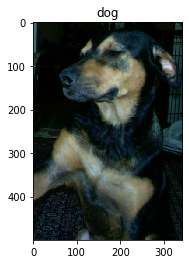

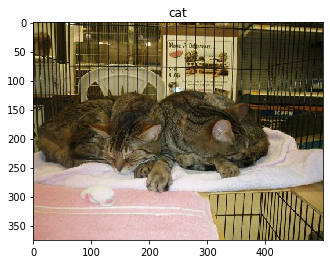

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

格式化数据<br>
使用该tf.image模块格式化任务的图像。

将图像调整为固定的输入尺寸，然后将输入通道调整为一定范围 [-1,1]

In [7]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

使用map方法将此函数应用于数据集中的每个项目：

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

现在，随机播放和批处理数据。

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

检查一批数据：

In [11]:
for image_batch, label_batch in train_batches.take(1):
     pass

image_batch.shape

TensorShape([32, 160, 160, 3])

从预训练的卷积网络创建基础模型<br>
您将根据Google开发的MobileNet V2模型创建基本模型。这在ImageNet数据集上进行了预训练，该图像数据集是一个包含140万个图像和1000类Web图像的大型数据集。ImageNet有一个相当随意的研究训练数据集，其分类为jackfruit和syringe，但是这一知识基础将帮助我们从特定数据集中区分猫和狗。

首先，您需要选择将用于功能提取的MobileNet V2的哪一层。显然，最后的分类层（在“顶部”，因为大多数机器学习模型的图是从底部到顶部）不是很有用。取而代之的是，您将按照常规做法改而依赖于展平操作之前的最后一层。该层称为“瓶颈层”。与最终/顶层相比，瓶颈功能保留了很多通用性。

首先，实例化一个预加载了ImageNet训练权重的MobileNet V2模型。通过指定include_top = False参数，可以加载不包含顶部分类层的网络，这对于特征提取是理想的。

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

该特征提取器将每个160x160x3图像转换为一个5x5x1280特征块。看看它对示例图像批次有什么作用：

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


特征提取<br>
您将冻结在上一步中创建的卷积基础，并将其用作特征提取器，在该基础上添加分类器，然后训练顶级分类器。

冻结卷积基础<br>
在编译和训练模型之前冻结基于卷积的数据非常重要。通过冻结（或设置layer.trainable = False），可以防止训练期间更新给定层中的权重。MobileNet V2有许多层，因此将整个模型的可训练标记设置为False会冻结所有层。

In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 20, 20, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 20, 20, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 20, 20, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 20, 20, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 20, 20, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 10, 10, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 10, 10, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 11, 11, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 5, 5, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 5, 5, 576)    2304        block_13_depthwise[0][0]         
__________

添加分类头<br>
为了从特征块生成预测，请对空间5x5空间位置进行平均，并使用tf.keras.layers.GlobalAveragePooling2D图层将特征转换为每个图像单个1280个元素的向量。

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


应用tf.keras.layers.Dense一层将这些特征转换为每个图像的单个预测。您在这里不需要激活函数，因为此预测将被视为logit或原始预测值。正数表示1类，负数表示0类。

In [18]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


现在，使用tf.keras.Sequential模型堆叠特征提取器和这两层：

In [19]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

编译模型<br>
您必须在训练模型之前对其进行编译。由于有两类，因此使用二进制交叉熵损失

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


MobileNet中的2.5M参数被冻结，但是在Dense层中有1.2K的可训练参数。这些分为tf.Variable权重和偏差两个对象。

In [22]:
len(model.trainable_variables)

2

训练模型<br>
训练10个纪元后，您应该会看到〜96％的准确性。

In [23]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHTS
)

In [24]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - ETA: 25s - loss: 5.1707 - accuracy: 0.468 - ETA: 8s - loss: 6.6566 - accuracy: 0.364 - ETA: 4s - loss: 6.9740 - accuracy: 0.33 - ETA: 2s - loss: 6.8774 - accuracy: 0.34 - ETA: 2s - loss: 6.7534 - accuracy: 0.34 - ETA: 1s - loss: 7.1620 - accuracy: 0.32 - ETA: 0s - loss: 7.0495 - accuracy: 0.33 - ETA: 0s - loss: 7.1596 - accuracy: 0.32 - ETA: 0s - loss: 7.3547 - accuracy: 0.32 - ETA: 0s - loss: 7.4371 - accuracy: 0.32 - 2s 106ms/step - loss: 7.4030 - accuracy: 0.3234


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 7.40
initial accuracy: 0.32


In [26]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


    167/Unknown - 4s 4s/step - loss: 6.3904 - accuracy: 0.34 - 4s 2s/step - loss: 6.3476 - accuracy: 0.28 - 4s 1s/step - loss: 5.8437 - accuracy: 0.35 - 4s 999ms/step - loss: 6.0821 - accuracy: 0.320 - 4s 816ms/step - loss: 6.2375 - accuracy: 0.306 - 4s 694ms/step - loss: 5.8811 - accuracy: 0.354 - 4s 608ms/step - loss: 5.8445 - accuracy: 0.370 - 4s 543ms/step - loss: 5.9680 - accuracy: 0.371 - 4s 492ms/step - loss: 6.1069 - accuracy: 0.361 - 5s 451ms/step - loss: 6.3657 - accuracy: 0.350 - 5s 418ms/step - loss: 6.1723 - accuracy: 0.369 - 5s 390ms/step - loss: 6.0394 - accuracy: 0.375 - 5s 366ms/step - loss: 6.1329 - accuracy: 0.372 - 5s 346ms/step - loss: 6.3665 - accuracy: 0.366 - 5s 328ms/step - loss: 6.3521 - accuracy: 0.368 - 5s 313ms/step - loss: 6.2483 - accuracy: 0.378 - 5s 299ms/step - loss: 6.2608 - accuracy: 0.380 - 5s 287ms/step - loss: 6.2102 - accuracy: 0.381 - 5s 276ms/step - loss: 6.2022 - accuracy: 0.384 - 5s 266ms/step - loss: 6.1084 - accuracy: 0.387 - 5s 257ms/step 

    334/Unknown - 17s 101ms/step - loss: 5.3572 - accuracy: 0.44 - 17s 101ms/step - loss: 5.3566 - accuracy: 0.44 - 17s 101ms/step - loss: 5.3523 - accuracy: 0.44 - 17s 101ms/step - loss: 5.3451 - accuracy: 0.44 - 17s 101ms/step - loss: 5.3380 - accuracy: 0.44 - 17s 100ms/step - loss: 5.3322 - accuracy: 0.44 - 17s 100ms/step - loss: 5.3456 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3346 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3282 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3253 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3132 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3199 - accuracy: 0.44 - 18s 100ms/step - loss: 5.3140 - accuracy: 0.44 - 18s 99ms/step - loss: 5.3050 - accuracy: 0.4484 - 18s 99ms/step - loss: 5.3091 - accuracy: 0.448 - 18s 99ms/step - loss: 5.3115 - accuracy: 0.448 - 18s 99ms/step - loss: 5.3003 - accuracy: 0.449 - 18s 99ms/step - loss: 5.2953 - accuracy: 0.448 - 18s 99ms/step - loss: 5.2864 - accuracy: 0.449 - 18s 99ms/step - loss: 5.2934 - accuracy: 0.449 - 1

    501/Unknown - 30s 91ms/step - loss: 4.5993 - accuracy: 0.511 - 30s 91ms/step - loss: 4.6031 - accuracy: 0.511 - 31s 91ms/step - loss: 4.5956 - accuracy: 0.512 - 31s 90ms/step - loss: 4.5920 - accuracy: 0.512 - 31s 90ms/step - loss: 4.5893 - accuracy: 0.512 - 31s 90ms/step - loss: 4.5832 - accuracy: 0.513 - 31s 90ms/step - loss: 4.5788 - accuracy: 0.513 - 31s 90ms/step - loss: 4.5770 - accuracy: 0.513 - 31s 90ms/step - loss: 4.5703 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5669 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5604 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5597 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5560 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5536 - accuracy: 0.514 - 31s 90ms/step - loss: 4.5483 - accuracy: 0.514 - 32s 90ms/step - loss: 4.5481 - accuracy: 0.515 - 32s 90ms/step - loss: 4.5414 - accuracy: 0.515 - 32s 90ms/step - loss: 4.5377 - accuracy: 0.516 - 32s 90ms/step - loss: 4.5349 - accuracy: 0.517 - 32s 90ms/step - loss: 4.5338 - accuracy: 0.517 - 32

582/582 [==============================]4.0037 - accuracy: 0.562 - 43s 86ms/step - loss: 4.0001 - accuracy: 0.563 - 44s 86ms/step - loss: 3.9986 - accuracy: 0.563 - 44s 86ms/step - loss: 3.9944 - accuracy: 0.563 - 44s 86ms/step - loss: 3.9918 - accuracy: 0.564 - 44s 86ms/step - loss: 3.9921 - accuracy: 0.564 - 44s 86ms/step - loss: 3.9876 - accuracy: 0.564 - 44s 86ms/step - loss: 3.9840 - accuracy: 0.564 - 44s 86ms/step - loss: 3.9816 - accuracy: 0.565 - 44s 86ms/step - loss: 3.9794 - accuracy: 0.565 - 44s 86ms/step - loss: 3.9758 - accuracy: 0.565 - 44s 86ms/step - loss: 3.9741 - accuracy: 0.566 - 44s 86ms/step - loss: 3.9717 - accuracy: 0.566 - 44s 86ms/step - loss: 3.9676 - accuracy: 0.566 - 44s 86ms/step - loss: 3.9664 - accuracy: 0.566 - 45s 86ms/step - loss: 3.9605 - accuracy: 0.567 - 45s 86ms/step - loss: 3.9575 - accuracy: 0.567 - 45s 86ms/step - loss: 3.9511 - accuracy: 0.567 - 45s 86ms/step - loss: 3.9478 - accuracy: 0.568 - 45s 86ms/step - loss: 3.9443 - accuracy: 0.568 - 45

582/582 [==============================] ETA: 1:27 - loss: 0.2785 - accuracy: 0.84 - ETA: 45s - loss: 1.1442 - accuracy: 0.8438 - ETA: 31s - loss: 1.6271 - accuracy: 0.822 - ETA: 24s - loss: 1.4798 - accuracy: 0.835 - ETA: 20s - loss: 1.2977 - accuracy: 0.856 - ETA: 17s - loss: 1.1753 - accuracy: 0.864 - ETA: 15s - loss: 1.1660 - accuracy: 0.866 - ETA: 14s - loss: 1.0514 - accuracy: 0.871 - ETA: 13s - loss: 1.0622 - accuracy: 0.864 - ETA: 12s - loss: 0.9765 - accuracy: 0.868 - ETA: 11s - loss: 1.0259 - accuracy: 0.869 - ETA: 10s - loss: 1.0262 - accuracy: 0.872 - ETA: 9s - loss: 1.0594 - accuracy: 0.875 - ETA: 9s - loss: 1.0324 - accuracy: 0.87 - ETA: 8s - loss: 1.0036 - accuracy: 0.87 - ETA: 8s - loss: 0.9879 - accuracy: 0.87 - ETA: 8s - loss: 0.9658 - accuracy: 0.87 - ETA: 7s - loss: 0.9523 - accuracy: 0.87 - ETA: 7s - loss: 0.9151 - accuracy: 0.87 - ETA: 7s - loss: 0.9190 - accuracy: 0.87 - ETA: 6s - loss: 0.9270 - accuracy: 0.87 - ETA: 6s - loss: 0.9192 - accuracy: 0.87 - ETA: 6s -

582/582 [==============================] ETA: 1:28 - loss: 2.0243 - accuracy: 0.81 - ETA: 46s - loss: 1.2883 - accuracy: 0.8750 - ETA: 32s - loss: 1.2383 - accuracy: 0.875 - ETA: 25s - loss: 1.0729 - accuracy: 0.890 - ETA: 21s - loss: 1.0132 - accuracy: 0.881 - ETA: 18s - loss: 0.8566 - accuracy: 0.895 - ETA: 16s - loss: 0.8357 - accuracy: 0.897 - ETA: 14s - loss: 0.8571 - accuracy: 0.902 - ETA: 13s - loss: 0.8414 - accuracy: 0.899 - ETA: 12s - loss: 0.8115 - accuracy: 0.903 - ETA: 11s - loss: 0.7947 - accuracy: 0.897 - ETA: 10s - loss: 0.7778 - accuracy: 0.895 - ETA: 10s - loss: 0.7405 - accuracy: 0.891 - ETA: 9s - loss: 0.7957 - accuracy: 0.890 - ETA: 9s - loss: 0.7920 - accuracy: 0.88 - ETA: 8s - loss: 0.8111 - accuracy: 0.88 - ETA: 8s - loss: 0.7675 - accuracy: 0.88 - ETA: 7s - loss: 0.7568 - accuracy: 0.89 - ETA: 7s - loss: 0.7491 - accuracy: 0.89 - ETA: 7s - loss: 0.7185 - accuracy: 0.89 - ETA: 7s - loss: 0.7098 - accuracy: 0.89 - ETA: 6s - loss: 0.6798 - accuracy: 0.90 - ETA: 6s

582/582 [==============================] ETA: 1:38 - loss: 0.0996 - accuracy: 0.96 - ETA: 51s - loss: 0.5774 - accuracy: 0.9375 - ETA: 35s - loss: 0.7304 - accuracy: 0.927 - ETA: 27s - loss: 0.6885 - accuracy: 0.929 - ETA: 22s - loss: 0.6704 - accuracy: 0.925 - ETA: 19s - loss: 0.5909 - accuracy: 0.932 - ETA: 17s - loss: 0.5902 - accuracy: 0.933 - ETA: 15s - loss: 0.5809 - accuracy: 0.937 - ETA: 14s - loss: 0.6840 - accuracy: 0.930 - ETA: 13s - loss: 0.6862 - accuracy: 0.921 - ETA: 12s - loss: 0.6431 - accuracy: 0.920 - ETA: 11s - loss: 0.5930 - accuracy: 0.924 - ETA: 10s - loss: 0.5525 - accuracy: 0.927 - ETA: 10s - loss: 0.5850 - accuracy: 0.926 - ETA: 9s - loss: 0.5797 - accuracy: 0.929 - ETA: 9s - loss: 0.6785 - accuracy: 0.91 - ETA: 8s - loss: 0.6434 - accuracy: 0.92 - ETA: 8s - loss: 0.6346 - accuracy: 0.92 - ETA: 7s - loss: 0.6299 - accuracy: 0.92 - ETA: 7s - loss: 0.6237 - accuracy: 0.92 - ETA: 7s - loss: 0.6477 - accuracy: 0.92 - ETA: 7s - loss: 0.6438 - accuracy: 0.92 - ETA: 

582/582 [==============================] ETA: 1:24 - loss: 0.0553 - accuracy: 0.96 - ETA: 44s - loss: 0.2872 - accuracy: 0.9531 - ETA: 31s - loss: 0.3586 - accuracy: 0.958 - ETA: 24s - loss: 0.2946 - accuracy: 0.953 - ETA: 20s - loss: 0.7302 - accuracy: 0.918 - ETA: 17s - loss: 0.7726 - accuracy: 0.921 - ETA: 15s - loss: 0.6682 - accuracy: 0.928 - ETA: 14s - loss: 0.5884 - accuracy: 0.937 - ETA: 12s - loss: 0.5350 - accuracy: 0.941 - ETA: 11s - loss: 0.4928 - accuracy: 0.937 - ETA: 11s - loss: 0.4480 - accuracy: 0.943 - ETA: 10s - loss: 0.5786 - accuracy: 0.932 - ETA: 9s - loss: 0.5432 - accuracy: 0.932 - ETA: 9s - loss: 0.5437 - accuracy: 0.93 - ETA: 8s - loss: 0.5093 - accuracy: 0.93 - ETA: 8s - loss: 0.5077 - accuracy: 0.93 - ETA: 8s - loss: 0.5178 - accuracy: 0.93 - ETA: 7s - loss: 0.5156 - accuracy: 0.93 - ETA: 7s - loss: 0.4920 - accuracy: 0.93 - ETA: 7s - loss: 0.4937 - accuracy: 0.93 - ETA: 6s - loss: 0.4957 - accuracy: 0.93 - ETA: 6s - loss: 0.4986 - accuracy: 0.93 - ETA: 6s -

学习曲线<br>
让我们看一下使用MobileNet V2基本模型作为固定功能提取器时训练和验证准确性/损失的学习曲线。

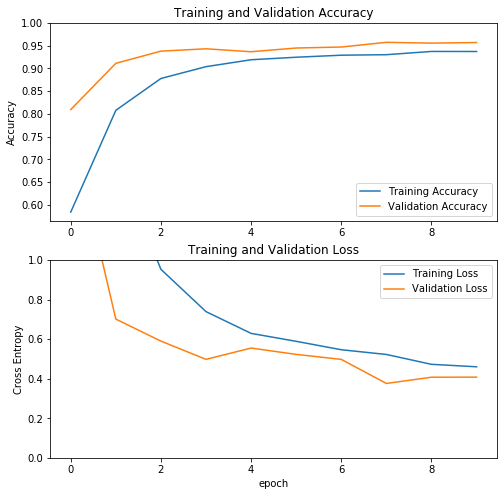

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

在较小程度上，这也是因为训练指标报告的是某个时期的平均值，而验证指标则是在该时期之后进行评估的，因此验证指标会看到训练时间更长的模型。

微调<br>
在我们的特征提取实验中，您仅在MobileNet V2基本模型之上训练了几层。训练过程中未更新预训练网络的权重。

进一步提高性能的一种方法是，对预训练模型顶层的权重进行训练（或“微调”），同时对您添加的分类器进行训练。训练过程将迫使权重从通用特征图调整为专门与我们的数据集相关联的特征。

注意：只有在您将顶级分类器训练为将预训练模型设置为不可训练之后，才可以尝试进行此操作。如果您在预训练模型的顶部添加随机初始化的分类器，并尝试共同训练所有图层，则梯度更新的幅度将太大（由于分类器的随机权重），因此预训练模型将忘记它学到的东西。

另外，您应该尝试微调少量顶层而不是整个MobileNet模型。在大多数卷积网络中，高层越高，它的专业性就越高。前几层学习非常简单且通用的功能，这些功能可以推广到几乎所有类型的图像。随着您的前进，这些功能将越来越多地针对训练模型的数据集。微调的目的是使这些专用功能适应新数据集，而不是覆盖常规学习。

解冻模型的顶层<br>
您所需要做的就是解冻base_model并设置底层不可训练。然后，您应该重新编译模型（这些更改才能生效），然后继续训练。

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


编译模型<br>
使用低得多的训练率来编译模型。

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [32]:
len(model.trainable_variables)

58

继续训练模型<br>
如果您早先进行了收敛的培训，这将使您的准确性提高百分之几。

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20


    167/Unknown - 6s 6s/step - loss: 1.5295 - accuracy: 0.84 - 6s 3s/step - loss: 1.3031 - accuracy: 0.87 - 6s 2s/step - loss: 0.9063 - accuracy: 0.90 - 6s 1s/step - loss: 0.8527 - accuracy: 0.88 - 6s 1s/step - loss: 0.7786 - accuracy: 0.90 - 6s 1000ms/step - loss: 0.6564 - accuracy: 0.91 - 6s 871ms/step - loss: 0.5825 - accuracy: 0.9152 - 6s 774ms/step - loss: 0.5882 - accuracy: 0.914 - 6s 698ms/step - loss: 0.5941 - accuracy: 0.909 - 6s 638ms/step - loss: 0.6831 - accuracy: 0.909 - 6s 588ms/step - loss: 0.6229 - accuracy: 0.917 - 7s 547ms/step - loss: 0.6520 - accuracy: 0.919 - 7s 513ms/step - loss: 0.6406 - accuracy: 0.920 - 7s 483ms/step - loss: 0.5959 - accuracy: 0.926 - 7s 458ms/step - loss: 0.5908 - accuracy: 0.929 - 7s 435ms/step - loss: 0.5608 - accuracy: 0.931 - 7s 415ms/step - loss: 0.6203 - accuracy: 0.928 - 7s 397ms/step - loss: 0.5877 - accuracy: 0.930 - 7s 382ms/step - loss: 0.5826 - accuracy: 0.932 - 7s 367ms/step - loss: 0.5780 - accuracy: 0.934 - 7s 354ms/step - loss:

    334/Unknown - 21s 127ms/step - loss: 0.4371 - accuracy: 0.94 - 21s 126ms/step - loss: 0.4406 - accuracy: 0.94 - 21s 126ms/step - loss: 0.4411 - accuracy: 0.94 - 22s 126ms/step - loss: 0.4388 - accuracy: 0.94 - 22s 126ms/step - loss: 0.4363 - accuracy: 0.94 - 22s 126ms/step - loss: 0.4342 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4515 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4491 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4469 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4446 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4451 - accuracy: 0.94 - 22s 125ms/step - loss: 0.4561 - accuracy: 0.94 - 22s 124ms/step - loss: 0.4537 - accuracy: 0.94 - 22s 124ms/step - loss: 0.4513 - accuracy: 0.94 - 23s 124ms/step - loss: 0.4544 - accuracy: 0.94 - 23s 124ms/step - loss: 0.4521 - accuracy: 0.94 - 23s 124ms/step - loss: 0.4498 - accuracy: 0.94 - 23s 124ms/step - loss: 0.4475 - accuracy: 0.94 - 23s 123ms/step - loss: 0.4453 - accuracy: 0.94 - 23s 123ms/step - loss: 0.4433 - accuracy: 0.94 - 23

    501/Unknown - 37s 110ms/step - loss: 0.4486 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4488 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4491 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4500 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4502 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4504 - accuracy: 0.94 - 37s 110ms/step - loss: 0.4535 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4522 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4551 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4554 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4541 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4528 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4529 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4530 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4545 - accuracy: 0.94 - 38s 110ms/step - loss: 0.4574 - accuracy: 0.94 - 38s 109ms/step - loss: 0.4575 - accuracy: 0.94 - 39s 109ms/step - loss: 0.4563 - accuracy: 0.94 - 39s 109ms/step - loss: 0.4552 - accuracy: 0.94 - 39s 109ms/step - loss: 0.4583 - accuracy: 0.94 - 39

582/582 [==============================] 0.4523 - accuracy: 0.94 - 53s 105ms/step - loss: 0.4525 - accuracy: 0.94 - 53s 105ms/step - loss: 0.4518 - accuracy: 0.94 - 53s 105ms/step - loss: 0.4518 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4530 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4522 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4523 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4515 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4526 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4518 - accuracy: 0.94 - 53s 104ms/step - loss: 0.4550 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4544 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4536 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4538 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4530 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4534 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4535 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4545 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4545 - accuracy: 0.94 - 54s 104ms/step - loss: 0.4538 - accuracy: 0.94 - 54

582/582 [==============================] ETA: 1:36 - loss: 0.5650 - accuracy: 0.90 - ETA: 51s - loss: 0.8196 - accuracy: 0.9062 - ETA: 35s - loss: 0.8819 - accuracy: 0.906 - ETA: 28s - loss: 0.6669 - accuracy: 0.929 - ETA: 23s - loss: 0.6299 - accuracy: 0.937 - ETA: 20s - loss: 0.6070 - accuracy: 0.942 - ETA: 18s - loss: 0.5887 - accuracy: 0.946 - ETA: 16s - loss: 0.5153 - accuracy: 0.953 - ETA: 15s - loss: 0.5744 - accuracy: 0.944 - ETA: 14s - loss: 0.5771 - accuracy: 0.943 - ETA: 13s - loss: 0.5250 - accuracy: 0.948 - ETA: 12s - loss: 0.4813 - accuracy: 0.953 - ETA: 11s - loss: 0.5289 - accuracy: 0.949 - ETA: 11s - loss: 0.4939 - accuracy: 0.950 - ETA: 10s - loss: 0.4610 - accuracy: 0.954 - ETA: 9s - loss: 0.4632 - accuracy: 0.955 - ETA: 9s - loss: 0.4641 - accuracy: 0.95 - ETA: 9s - loss: 0.4392 - accuracy: 0.95 - ETA: 8s - loss: 0.4163 - accuracy: 0.96 - ETA: 8s - loss: 0.3955 - accuracy: 0.96 - ETA: 8s - loss: 0.3768 - accuracy: 0.96 - ETA: 7s - loss: 0.3639 - accuracy: 0.96 - ETA

582/582 [==============================] ETA: 1:30 - loss: 2.3924e-04 - accuracy: 1.00 - ETA: 47s - loss: 0.0068 - accuracy: 1.0000     - ETA: 33s - loss: 0.0045 - accuracy: 1.000 - ETA: 26s - loss: 0.0051 - accuracy: 1.000 - ETA: 22s - loss: 0.0056 - accuracy: 1.000 - ETA: 19s - loss: 0.0053 - accuracy: 1.000 - ETA: 17s - loss: 0.0753 - accuracy: 0.995 - ETA: 15s - loss: 0.0784 - accuracy: 0.992 - ETA: 14s - loss: 0.0720 - accuracy: 0.993 - ETA: 13s - loss: 0.0650 - accuracy: 0.993 - ETA: 12s - loss: 0.0697 - accuracy: 0.988 - ETA: 11s - loss: 0.0663 - accuracy: 0.987 - ETA: 11s - loss: 0.1042 - accuracy: 0.983 - ETA: 10s - loss: 0.0993 - accuracy: 0.982 - ETA: 9s - loss: 0.0946 - accuracy: 0.981 - ETA: 9s - loss: 0.0915 - accuracy: 0.98 - ETA: 9s - loss: 0.0906 - accuracy: 0.98 - ETA: 8s - loss: 0.0872 - accuracy: 0.98 - ETA: 8s - loss: 0.0828 - accuracy: 0.98 - ETA: 8s - loss: 0.0786 - accuracy: 0.98 - ETA: 7s - loss: 0.0757 - accuracy: 0.98 - ETA: 7s - loss: 0.0976 - accuracy: 0.98

582/582 [==============================] ETA: 1:30 - loss: 0.0124 - accuracy: 1.00 - ETA: 47s - loss: 0.0062 - accuracy: 1.0000 - ETA: 33s - loss: 0.0056 - accuracy: 1.000 - ETA: 26s - loss: 0.0042 - accuracy: 1.000 - ETA: 22s - loss: 0.0033 - accuracy: 1.000 - ETA: 19s - loss: 0.0032 - accuracy: 1.000 - ETA: 17s - loss: 0.0228 - accuracy: 0.991 - ETA: 15s - loss: 0.0200 - accuracy: 0.992 - ETA: 14s - loss: 0.0710 - accuracy: 0.989 - ETA: 13s - loss: 0.0639 - accuracy: 0.990 - ETA: 12s - loss: 0.1019 - accuracy: 0.988 - ETA: 11s - loss: 0.1776 - accuracy: 0.979 - ETA: 11s - loss: 0.1640 - accuracy: 0.980 - ETA: 10s - loss: 0.1867 - accuracy: 0.979 - ETA: 9s - loss: 0.2064 - accuracy: 0.979 - ETA: 9s - loss: 0.1943 - accuracy: 0.98 - ETA: 9s - loss: 0.1828 - accuracy: 0.98 - ETA: 8s - loss: 0.1732 - accuracy: 0.98 - ETA: 8s - loss: 0.1642 - accuracy: 0.98 - ETA: 8s - loss: 0.1801 - accuracy: 0.98 - ETA: 7s - loss: 0.1763 - accuracy: 0.98 - ETA: 7s - loss: 0.1686 - accuracy: 0.98 - ETA: 

582/582 [==============================] ETA: 1:30 - loss: 0.0817 - accuracy: 0.93 - ETA: 48s - loss: 0.2805 - accuracy: 0.9531 - ETA: 33s - loss: 0.1870 - accuracy: 0.968 - ETA: 26s - loss: 0.1402 - accuracy: 0.976 - ETA: 22s - loss: 0.1134 - accuracy: 0.981 - ETA: 19s - loss: 0.0955 - accuracy: 0.984 - ETA: 17s - loss: 0.0823 - accuracy: 0.986 - ETA: 15s - loss: 0.1323 - accuracy: 0.984 - ETA: 14s - loss: 0.1176 - accuracy: 0.986 - ETA: 13s - loss: 0.1058 - accuracy: 0.987 - ETA: 12s - loss: 0.1469 - accuracy: 0.980 - ETA: 11s - loss: 0.1475 - accuracy: 0.974 - ETA: 11s - loss: 0.1361 - accuracy: 0.976 - ETA: 10s - loss: 0.1280 - accuracy: 0.975 - ETA: 10s - loss: 0.1519 - accuracy: 0.975 - ETA: 9s - loss: 0.1442 - accuracy: 0.974 - ETA: 9s - loss: 0.1421 - accuracy: 0.97 - ETA: 8s - loss: 0.1344 - accuracy: 0.97 - ETA: 8s - loss: 0.1561 - accuracy: 0.97 - ETA: 8s - loss: 0.1496 - accuracy: 0.97 - ETA: 7s - loss: 0.1429 - accuracy: 0.97 - ETA: 7s - loss: 0.1364 - accuracy: 0.97 - ETA

当微调MobileNet V2基本模型的最后几层并在其之上训练分类器时，让我们看一下训练和验证准确性/损失的学习曲线。验证损失比训练损失高得多，因此您可能会感到过拟合。

由于新的训练集相对较小，并且与原始MobileNet V2数据集相似，因此您可能还会感到过拟合。

进行微调后，模型的精度几乎达到98％。

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

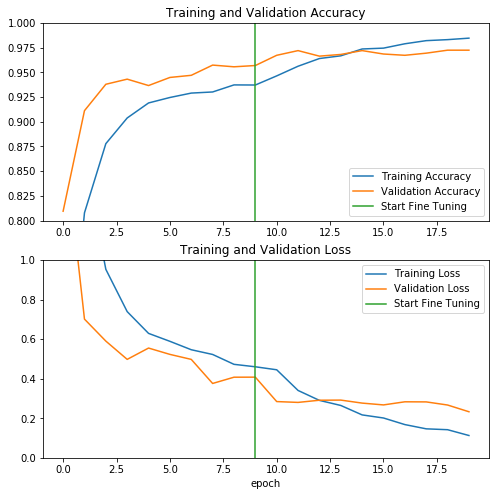

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

摘要：<br>
* 使用预先训练的模型进行特征提取：使用小型数据集时，通常利用在相同域中的大型数据集上训练的模型中学习的特征。这是通过实例化预训练的模型并在顶部添加一个完全连接的分类器来完成的。预先训练的模型是“冻结的”，训练过程中仅更新分类器的权重。在这种情况下，卷积基础提取了与每个图像关联的所有特征，而您只是训练了一个分类器，该分类器根据提取的特征集确定图像类。

* 微调预训练的模型：为了进一步提高性能，可能需要通过微调将预训练的模型的顶层重新用于新的数据集。在这种情况下，您可以调整权重，以使模型学习到特定于数据集的高级功能。通常在训练数据集很大且与训练前模型训练的原始数据集非常相似时，建议使用此技术。